In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip uninstall tensorflow
!pip install pytorch_lightning

Mounted at /content/drive
Fri Dec  9 02:21:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
#from ctypes import FormatError
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os,sys

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
# sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))

import torch
torch.use_deterministic_algorithms(True)

from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE
from torchmetrics import R2Score, SymmetricMeanAbsolutePercentageError, MeanSquaredError

import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle
from pytorch_forecasting import Baseline
import random
from pytorch_forecasting import DeepAR,NegativeBinomialDistributionLoss
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
"""
Set Random seed
"""

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
## additional seeding to ensure reproduciblility.
pl.seed_everything(0)

import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master/1_cluster_demand_prediction')

INFO:lightning_lite.utilities.seed:Global seed set to 0


In [ ]:
encoder_len = 48
pred_len = 1 # 1, 6, 12 
cov_lag_len= pred_len

In [ ]:
(20+cov_lag_len)%24

21

In [ ]:
"""
Import pre-processed Data

response and target are the same thing
"""
with open("final_response_ts_tampines_medium_dataset.pkl",'rb') as f:
    final_response_ts = pickle.load(f)

with open("final_num_covariate_ts_tampines_medium_dataset.pkl",'rb') as f:
    final_num_covariate_ts = pickle.load(f)

with open("final_cat_covariate_ts_tampines_medium_dataset.pkl",'rb') as f:
    final_cat_covariate_ts = pickle.load(f)

###### concatenate response and covariate time series into a single dataframe  #########
df3 = pd.DataFrame(final_response_ts) # response and target are the same thing
# Remove the excess cov_lag_len hours for lagging covariate time series by 24 hours
df3 = pd.DataFrame(df3.iloc[cov_lag_len:]).reset_index(drop=True)

df4 = pd.DataFrame(final_num_covariate_ts)
# lag covariate time series by cov_lag_len hours to turn it into a 'time_varying_unknown_real' variable
df4 = pd.DataFrame(df4.iloc[:-cov_lag_len]).reset_index(drop=True)

df5 = pd.DataFrame(final_cat_covariate_ts)
# lag covariate time series by cov_lag_len hours to turn it into a 'time_varying_unknown_real' variable
df5 = pd.DataFrame(df5.iloc[:-cov_lag_len]).reset_index(drop=True)

df6 = pd.concat([df5,df4], axis=1) # dataframe of all covariates

df1 = pd.DataFrame({"time_idx":np.arange(0,len(df3))})
df2 = pd.DataFrame({"group":np.tile(0,len(df3))}) # identifies the series in case of univariate and multivariate series
df = pd.concat([df1,df2,df3,df6], axis=1)
###### concatenate response and covariate time series into a single dataframe  #########


#################### add date information ts ####################
#2021 oct 17 20:00:00
day=17
hour=(20+cov_lag_len)
if (20+cov_lag_len)>23:
  day = 18
  hour = hour%24

df["date"] = pd.Timestamp(year=2021, month=10, day=day, hour=hour ) + pd.to_timedelta(df.time_idx, "H")
df['_hour_of_day'] = df["date"].dt.hour.astype(str)
df['_day_of_week'] = df["date"].dt.dayofweek.astype(str)
df['_day_of_month'] = df["date"].dt.day.astype(str)
df['_day_of_year'] = df["date"].dt.dayofyear.astype(str)
df['_week_of_year'] = df["date"].dt.weekofyear.astype(str)
df['_month_of_year'] = df["date"].dt.month.astype(str)
df['_year'] = df["date"].dt.year.astype(str)
#################### add date information ts ####################

Target = list(final_response_ts.keys())[0] # response and target are the same thing
chosen = Target[6:]

tr_stop_idx = int(0.7*len(df3))
val_start_idx = tr_stop_idx - encoder_len
val_stop_idx = val_start_idx + int(0.2*len(df3)) # use (tr_stop_idx - encoder_len) as encoder from train set for validatoin
tes_start_idx = val_stop_idx - encoder_len
tes_stop_idx = len(df3)

print(tr_stop_idx)
print(val_start_idx)
print(val_stop_idx)
print(tes_start_idx)
print(tes_stop_idx)

cat_col1 = list(final_cat_covariate_ts.keys())[0] # for column name agnostic
# cat_col2 = list(final_cat_covariate_ts.keys())[1] # for column name agnostic
# cat_col3 = list(final_cat_covariate_ts.keys())[2] # for column name agnostic
# cat_col4 = list(final_cat_covariate_ts.keys())[3] # for column name agnostic

#num_cols_list = list(final_num_covariate_ts.keys())[:3] # for column name agnostic
#num_cols_list.append(Target) # for column name agnostic

1116
1068
1387
1339
1595


In [ ]:
print(list(df6.columns))

['wea_desc_clstr_175', 'temp_clstr_175', 'hum_clstr_175', 'clstr_171', 'clstr_168', 'clstr_175_lag_168', 'clstr_175_lag_336', '175_inflow', '175_lag_168_inflow', '175_lag_336_inflow']


In [ ]:
cov = list(df6.columns)
cov = cov[:-6] # remove one extra covariate to reduce hyperparam comb. However, these are added again below for every hparams comb.
print(cov)

cov_pairs_list = []
for p in combinations(cov,2):
  cov_pairs_list.append(p)

['wea_desc_clstr_175', 'temp_clstr_175', 'hum_clstr_175', 'clstr_171']


In [ ]:
cov_pairs_list

[('wea_desc_clstr_175', 'temp_clstr_175'),
 ('wea_desc_clstr_175', 'hum_clstr_175'),
 ('wea_desc_clstr_175', 'clstr_171'),
 ('temp_clstr_175', 'hum_clstr_175'),
 ('temp_clstr_175', 'clstr_171'),
 ('hum_clstr_175', 'clstr_171')]

In [ ]:
"""
set inputs here
(hyperparameters grid search)

"""
######### Network Architecture ###################


###### Create hyperparameters grid ###### 

hparams_grid = {"LSTM_neuron_size":[168],
	            "num_layers":[3],
                "batch_size":[4],
                "learning_rate":[0.0001],
                "max_encoder_length":[encoder_len],
                "max_prediction_length":[pred_len],
                "dropout":[0.2],
                "cov_pair":cov_pairs_list,# [cov_pairs_list[7]],
	            "Num_epochs":[26]}
###### Create hyperparameters grid ###### 

p = 10 # patience no. of epochs

Loss=NegativeBinomialDistributionLoss()

######### Network Architecture ###################
 




######### Training Routine ###################
fdv_steps = 10 # fast_dev_run
######### Training Routine ###################


############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################
season_len = 168 # length of season
num_past_seas = 6 # number of past seasons to use in averaging
#seas_pred_strt_idx = 2035 # seasonal naive forecast start index, in hours use the df dataframe
############## Inputs for 2) Persistance model ( seasonal naive forecast ) #######################


param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,cov_pair,num_ep in product(*[x for x in hparams_grid.values()]):
    #print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2)
    param_comb_cnt+=1
param_comb_cnt

6

In [ ]:
"""
Data loading sanity check

"""

######## View the entire data using this code ##################
#print(train_dataset.data['categoricals'])
######## View the data entire using this code ##################

######## View the data for each batch using this code ##################
# for x,y in iter(train_dataloader):
#     print(x["encoder_cat"][0][0:72,2])
#     break
######## View the data for each batch using this code ##################


'\nData loading sanity check\n\n'

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.c

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


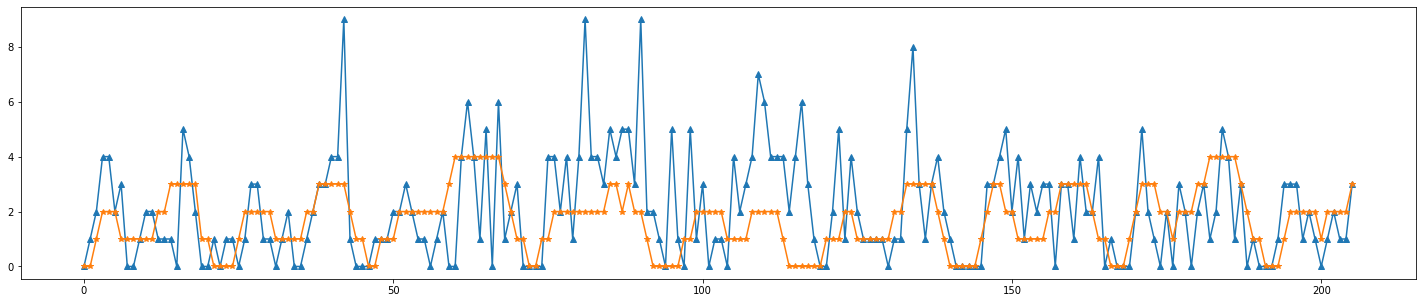

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Average RMSE for 206 days:  1.3155339805825244
full average RMSE =  1.8473281677123048

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

0 168 3 4 0.0001 48 1 0.2 26 wea_desc_clstr_175 temp_clstr_175  



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 2.0 K 
3 | rnn                    | LSTM                             | 614 K 
4 | distribution_projector | Linear                           | 338   
----------------------------------------------------------------------------
616 K     Trainable params
0         Non-trainable params
616 K     Total params
2.466     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


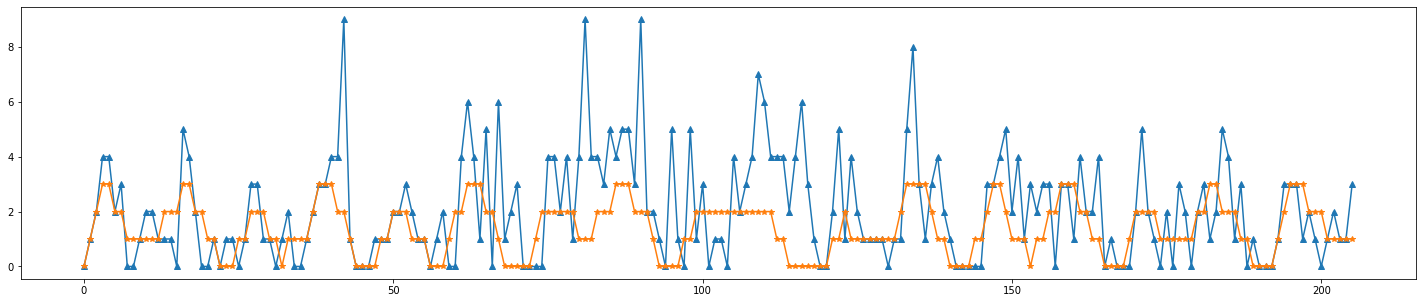

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Average RMSE for 206 days:  1.2815533980582525
full average RMSE =  1.8901892852253137

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

1 168 3 4 0.0001 48 1 0.2 26 wea_desc_clstr_175 hum_clstr_175  



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 2.0 K 
3 | rnn                    | LSTM                             | 614 K 
4 | distribution_projector | Linear                           | 338   
----------------------------------------------------------------------------
616 K     Trainable params
0         Non-trainable params
616 K     Total params
2.466     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


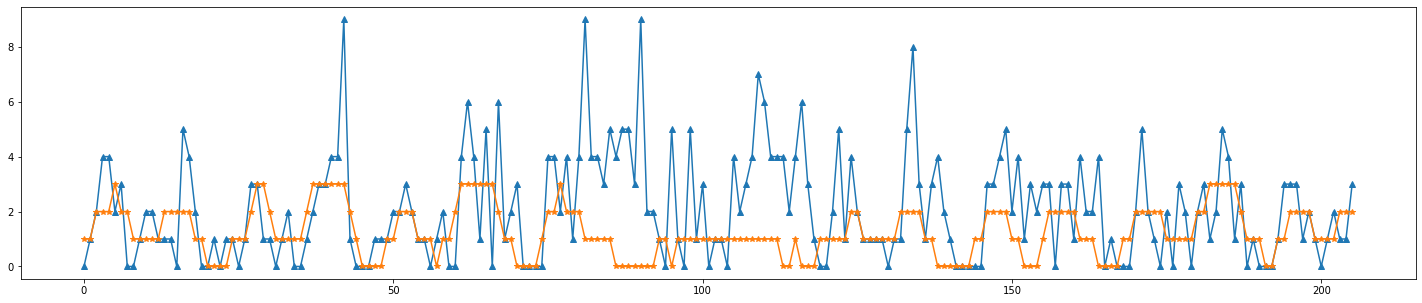

Average RMSE for 206 days:  1.4563106796116505
full average RMSE =  2.092520197441121

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

2 168 3 4 0.0001 48 1 0.2 26 wea_desc_clstr_175 clstr_171  



/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.c

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


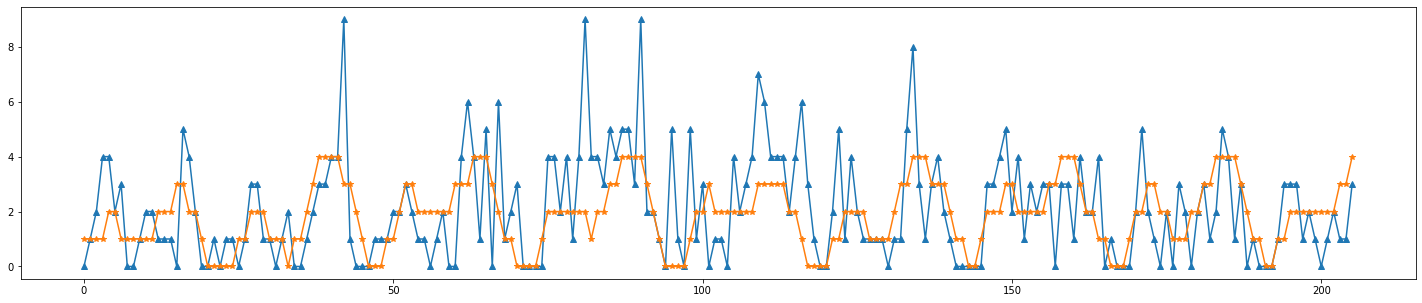

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


Average RMSE for 206 days:  1.2572815533980584
full average RMSE =  1.7418325357290443

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

3 168 3 4 0.0001 48 1 0.2 26 temp_clstr_175 hum_clstr_175  



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 1.9 K 
3 | rnn                    | LSTM                             | 609 K 
4 | distribution_projector | Linear                           | 338   
----------------------------------------------------------------------------
611 K     Trainable params
0         Non-trainable params
611 K     Total params
2.447     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


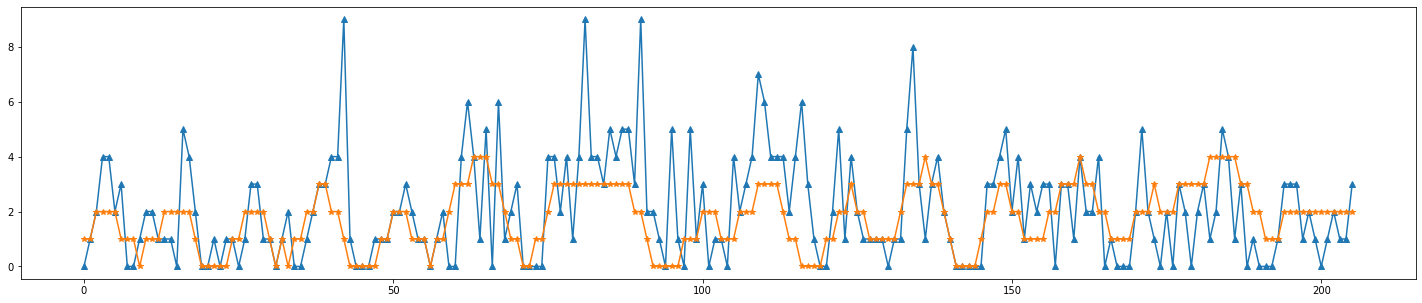

Average RMSE for 206 days:  1.203883495145631
full average RMSE =  1.762610596956927

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

4 168 3 4 0.0001 48 1 0.2 26 temp_clstr_175 clstr_171  



/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.c

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=26` reached.


Predict:   0%|          | 0/52 [00:00<?, ? batches/s]

pred_start_idx =  2021-12-14 16:00:00 1387


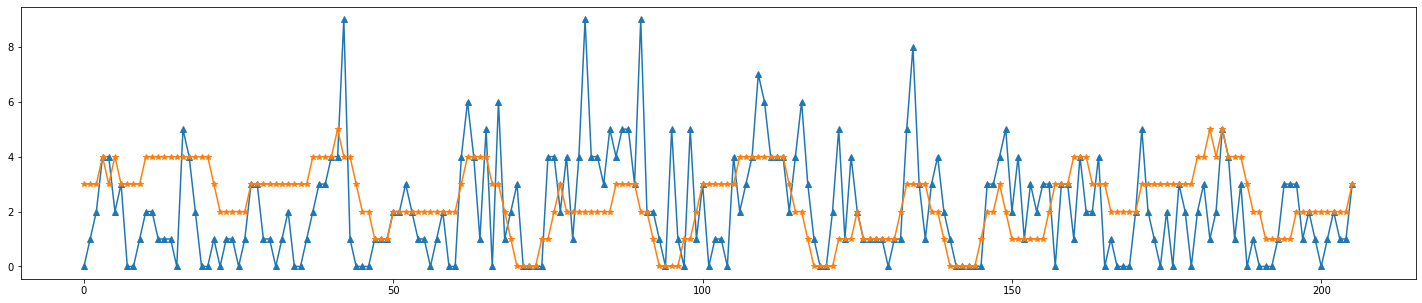

Average RMSE for 206 days:  1.5194174757281553
full average RMSE =  2.0060587839493125

 Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow

5 168 3 4 0.0001 48 1 0.2 26 hum_clstr_175 clstr_171  



In [ ]:
"""
Full Training Routine 
with hyperparmeter grid search

Load data into TimeSeriesDataSet object

for fast development run
uncomment fast_dev_run = fdv_steps

"""

#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=p, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

RMSE_list = [] # FIND minimum RMSE case
hyperparams_list = [] # FIND minimum RMSE case

# best_val_comb_idx=[17,21,51,52,53,54,61,62,63,82,83,84,109,110,111,143,144,145,195,218,219,220,232,233,234,236,237,238,280,338,339,340,344,345,346,386]
# best_val_train_epochs = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

# best_val_comb_idx=[234]
# best_val_train_epochs = [50]


param_comb_cnt=-1
for neu,lay,bat,lr,enc_len,pred_len,drop,cov_pair,num_ep in product(*[x for x in hparams_grid.values()]):

  num_cols_list = []  
  param_comb_cnt+=1
  if param_comb_cnt <0 or param_comb_cnt > 253:
    continue

  df_cov_col1 = cov_pair[0]
  df_cov_col2 = cov_pair[1]

    ######### Load DATA #############

  if (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] != 'wea'): 
        num_cols_list = [df_cov_col2]
        cat_col1 = df_cov_col1
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  elif (df_cov_col2[:3] == 'wea' and df_cov_col1[:3] != 'wea'): 
        num_cols_list = [df_cov_col1]
        cat_col1 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  elif (df_cov_col1[:3] == 'wea' and df_cov_col2[:3] == 'wea'): 
        num_cols_list = []
        cat_col1 = df_cov_col1
        cat_col2 = df_cov_col2
        cat_dict = {cat_col1: NaNLabelEncoder(add_nan=True).fit(df[cat_col1]),cat_col2: NaNLabelEncoder(add_nan=True).fit(df[cat_col2]),"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year)}
        cat_list = [cat_col1,cat_col2,"_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  else:
        num_cols_list = [df_cov_col1,df_cov_col2] # numerical covariate
        cat_dict = {"_hour_of_day": NaNLabelEncoder(add_nan=True).fit(df._hour_of_day), \
        "_day_of_week": NaNLabelEncoder(add_nan=True).fit(df._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(df._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(df._day_of_year), \
            "_week_of_year": NaNLabelEncoder(add_nan=True).fit(df._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(df._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(df._year),\
            'wea_desc_clstr_'+chosen: NaNLabelEncoder(add_nan=True).fit(df['wea_desc_clstr_'+chosen]) }
        cat_list = ["_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year"]
  
  num_cols_list.append('clstr_'+chosen+'_lag_168') 
  num_cols_list.append('clstr_'+chosen+'_lag_336')
  num_cols_list.append(chosen+'_inflow')
  num_cols_list.append(chosen+'_lag_168_inflow')  
  num_cols_list.append(chosen+'_lag_336_inflow')
  #cat_list.append('wea_desc_clstr_52')

  train_dataset = TimeSeriesDataSet(
      df.iloc[0:tr_stop_idx],
      time_idx="time_idx",
      target=Target,
      categorical_encoders=cat_dict,
      group_ids=["group"],
      min_encoder_length=enc_len,
      max_encoder_length=enc_len,
      min_prediction_length=pred_len,
      max_prediction_length=pred_len,
      time_varying_unknown_reals=[Target],
      time_varying_known_reals=num_cols_list,
      time_varying_known_categoricals=cat_list,
      add_relative_time_idx=False,
      randomize_length=False,
      scalers={},
      target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

  )

  val_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[val_start_idx:val_stop_idx], stop_randomization=True, predict=False)
  test_dataset = TimeSeriesDataSet.from_dataset(train_dataset,df.iloc[tes_start_idx:tes_stop_idx], stop_randomization=True)

  train_dataloader = train_dataset.to_dataloader(train=True, batch_size=bat)
  val_dataloader = val_dataset.to_dataloader(train=False, batch_size=bat)
  test_dataloader = test_dataset.to_dataloader(train=False, batch_size=bat)
  ######### Load DATA #############


  """
  Machine Learning predictions START
  1) DeepAR

  """
  trainer = pl.Trainer(
      max_epochs=num_ep,
      gpus=-1, #-1
      auto_lr_find=False,
      gradient_clip_val=0.1,
      limit_train_batches=1.0,
      limit_val_batches=1.0,
      #fast_dev_run=fdv_steps,
      logger=True,
      #log_every_n_steps=10,
      # profiler=True,
      callbacks=[lr_logger]#, early_stop_callback],
      #enable_checkpointing=True,
      #default_root_dir="C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\logs"
  )


  #print(f"training routing:\n \n {trainer}")
  deepar = DeepAR.from_dataset(
      train_dataset,
      learning_rate=lr,
      hidden_size=neu,
      rnn_layers=lay,
      dropout=drop,
      loss=Loss,
      log_interval=20,
      log_val_interval=6,
      log_gradient_flow=False,
      # reduce_on_plateau_patience=3,
  )

    
  #print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")
  # print(f"Model :\n \n {deepar}")
  torch.set_num_threads(10)
  trainer.fit(
      deepar,
      train_dataloaders=train_dataloader,
      val_dataloaders=val_dataloader,
  )

  ########## Prediction #####################

  test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)

  pred_start_idx = int(test_output[1]['time_idx'][0])

  actual1_full = np.array([])
  pred_full = np.array([])  
  RMSE_list = np.array([])
  days = tes_stop_idx - val_stop_idx - pred_len - pred_len

  for j in range(0,days,pred_len):

    if j == 0:
      print('pred_start_idx = ',df["date"].iloc[pred_start_idx],pred_start_idx )

    actual = df[Target].iloc[pred_start_idx+(j):pred_start_idx+(j)+pred_len].values
    actual1_full = np.append(actual1_full, actual)
    #plt.plot(actual,'*-')
    pred = np.array(np.rint(test_output[0][j])).astype(int)
    pred_full = np.append(pred_full, pred)
    #plt.plot(pred,'^-')
    #plt.show()

    RMSE = np.sqrt(mean_squared_error(actual,pred ))
    #print('RMSE : ',RMSE)
    RMSE_list = np.append(RMSE_list,RMSE) 

  plt.figure(figsize=(25,5))
  plt.plot(actual1_full.flatten(),'^-')
  plt.plot(pred_full.flatten(),'*-')
  plt.show()

  print(f'Average RMSE for {days} days: ',np.mean(RMSE_list))
  print('full average RMSE = ',np.sqrt(mean_squared_error(actual1_full.flatten(),pred_full.flatten() )))

  print('\n Hyperparameter: param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,inflow\n')
  print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2,' \n')
  ########## Prediction #####################
    
  # TO find minimum RMSE
  hyperparams_list.append((neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2))
  # RMSE_list.append(RMSE)

  

  """
  Machine Learning predictions END
  """

######## Identify least RMSE case #############
# min_RMSE_idx = RMSE_list.index(min(RMSE_list))
# hyperparams_list[min_RMSE_idx]

######## Identify least RMSE case #############





In [ ]:
"""
View tensorboard logs

"""


'\nView tensorboard logs\n\n'

pred_start_idx 1387


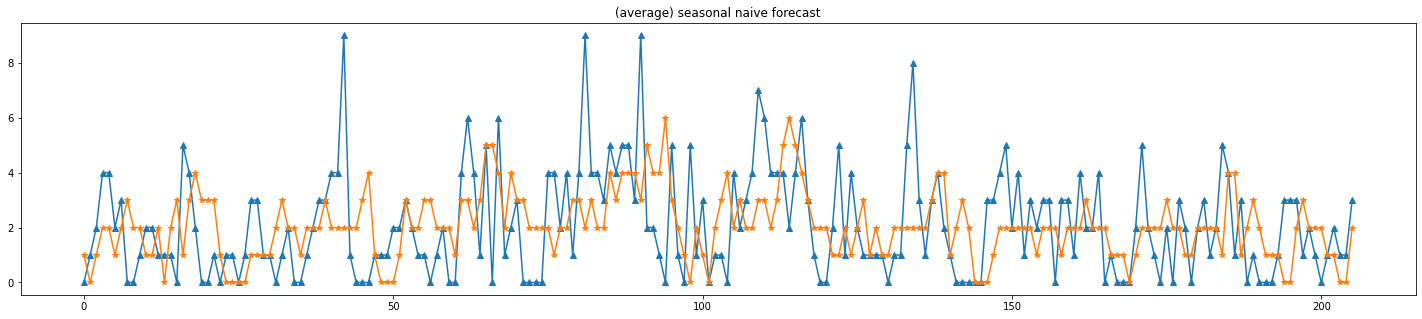

Average RMSE for 206 days:  1.587378640776699
full average RMSE =  2.0491532705519107
Average RMSE for 206 days:  1.587378640776699


In [ ]:
"""
Baseline predictions START
1) Persistance model (last value)

2) Persistance model ( seasonal naive forecast )
"""
############## 1) Persistance model (last value) #######################
# actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# baseline_predictions = Baseline().predict(test_dataloader)
# print(f" Persistance model (last value), sMAPE : {SMAPE()(baseline_predictions, actuals)}")
# print(f" Persistance model (last value), RMSE : {RMSE()(baseline_predictions,actuals)}")
# r2score = R2Score()
# print(f" Persistance model (last value), R2 Score : { np.mean([ r2score(baseline_predictions[i], actuals[i])    for i in range(len(actuals)) ]) }" )
############## 1) Persistance model (last value) #######################

############## 2) Persistance model ( seasonal naive forecast ) #######################
# days=5
# pred_start_idx=2020
predictions_list = np.array([])
actuals1_list = np.array([])


RMSE_list = np.array([])

for j in range(0,days,pred_len):
  predictions = np.array([])
  strt_idx = pred_start_idx+(j)
  actuals1 = df[Target].iloc[strt_idx:strt_idx+pred_len].values
  for h in range(pred_len):
      sum1 = 0
      for n in range(num_past_seas):
        o=4 if n%2==0 else 1
        sum1 = sum1 + df[Target][strt_idx-o+h - season_len*n]
      
      predictions = np.append(predictions,sum1/num_past_seas)

  predictions = np.rint(predictions).astype(int)
  predictions_list=np.append(predictions_list,predictions)
  actuals1 = np.array(actuals1)
  actuals1_list=np.append(actuals1_list,actuals1)
  #print(actuals1_list)

  smape = SymmetricMeanAbsolutePercentageError()
  mse = MeanSquaredError()
  #print(f"\nseasonal prediction start index:  {strt_idx}")
  #print(f" Persistance model ( seasonal naive forecast ) , RMSE : {np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))}")
  RMSE = np.sqrt(mse(torch.Tensor(predictions),torch.Tensor(actuals1)))
  RMSE_list = np.append(RMSE_list,RMSE)
  # plt.title("(average) seasonal naive forecast")
  # plt.plot(predictions,color='r')
  # plt.plot(actuals1,color='b')
  # plt.show()

plt.figure(figsize=(25,5))
plt.title("(average) seasonal naive forecast")
print('pred_start_idx',pred_start_idx)
plt.plot(actuals1_list.flatten(),'^-')
plt.plot(predictions_list.flatten(),'*-')
plt.show()


print(f'Average RMSE for {days} days: ',np.mean(RMSE_list))
print('full average RMSE = ',np.sqrt(mean_squared_error(actuals1_list.flatten(),predictions_list.flatten() )))
############## 2) Persistance model ( seasonal naive forecast ) #######################
"""
Baseline predictions END
"""    


      # peak prediction metric
  # error wrt 10 largest peaks 
  



print(f'Average RMSE for {days} days: ',np.mean(RMSE_list))


In [ ]:
actuals1_list

array([0., 1., 2., 4., 4., 2., 3., 0., 0., 1., 2., 2., 1., 1., 1., 0., 5.,
       4., 2., 0., 0., 1., 0., 1., 1., 0., 1., 3., 3., 1., 1., 0., 1., 2.,
       0., 0., 1., 2., 3., 3., 4., 4., 9., 1., 0., 0., 0., 1., 1., 1., 2.,
       2., 3., 2., 1., 1., 0., 1., 2., 0., 0., 4., 6., 4., 1., 5., 0., 6.,
       1., 2., 3., 0., 0., 0., 0., 4., 4., 2., 4., 1., 4., 9., 4., 4., 3.,
       5., 4., 5., 5., 3., 9., 2., 2., 1., 0., 5., 1., 0., 5., 1., 3., 0.,
       1., 1., 0., 4., 2., 3., 4., 7., 6., 4., 4., 4., 2., 4., 6., 3., 1.,
       0., 0., 2., 5., 1., 4., 2., 1., 1., 1., 1., 0., 1., 1., 5., 8., 3.,
       1., 3., 4., 2., 1., 0., 0., 0., 0., 0., 3., 3., 4., 5., 2., 4., 1.,
       3., 2., 3., 3., 0., 3., 3., 1., 4., 2., 2., 4., 0., 1., 0., 0., 0.,
       2., 5., 2., 1., 0., 2., 0., 3., 2., 0., 2., 3., 1., 2., 5., 4., 1.,
       3., 0., 1., 0., 0., 0., 1., 3., 3., 3., 1., 2., 1., 0., 1., 2., 1.,
       1., 3.])